# Integrating multiple scRNA-seq data

This tutorial shows loading, preprocessing, DAVAE integration and visualization of 293T and Jurkat cells in three different batches (Mixed Cell Lines).

### Importing scbean package
Here, we'll import scbean along with other popular packages.

In [1]:
import pandas as pd
import scbean.model.davae as davae
import scbean.tools.utils as tl
import scanpy as sc
import matplotlib
from numpy.random import seed
seed(2021)
matplotlib.use('TkAgg')

# Command for Jupyter notebooks only
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

/Users/wangyuwei/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/Users/wangyuwei/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Loading data
This tutorial uses Mixed Cell Line datasets from [10xgenomics](https://www.10xgenomics.com/cn/) with non-overlapping populations from three batches, two of which contain 293t (2885 cells) and jurkat (3258 cells) cells respectively, and the third batch contains a 1:1 mixture of 293t and jurkat cells (3388 cells).

- Read from 10x mtx file\
The file in 10x mtx format can be downloaded [here](https://support.10xgenomics.com/single-cell-gene-expression/datasets/). Set the fmt parameter of pp.read_sc_data() function to '10x_mtx' to read the data downloaded from 10XGenomics. If the file downloaded from 10XGenomics is in h5 format, the dataset can be loaded by setting the fmt parameter to '10x_h5'.

In [2]:
file1 = './data/' + "293t/hg19/"
file2 = './data/' + "jurkat/hg19/"
file3 = './data/' + "jurkat_293t/hg19/"

adata_b1 = tl.read_sc_data(file1, fmt='10x_mtx', batch_name="293t")
adata_b2 = tl.read_sc_data(file2, fmt='10x_mtx', batch_name="jurkat")
adata_b3 = tl.read_sc_data(file3, fmt='10x_mtx', batch_name="mixed")

### Data preprocessing
Here, we filter and normalize each data separately and concatenate them into one AnnData object. For more details, please check the preprocessing [API](https://scbean.readthedocs.io/en/latest/api.html#module-scbean.tools.utils).

In [3]:
adata_all = tl.davae_preprocessing([adata_b1, adata_b2, adata_b3], index_unique="-")

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


### DAVAE Integration
The code for integration using davae is as following:

In [4]:
# Command for Jupyter notebooks only
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

adata_integrate = davae.fit_integration(
    adata_all,
    batch_num=3,
    domain_lambda=0.7,
    epochs=25,
    sparse=True,
    hidden_layers=[64, 32, 6]
)

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 2000)]       0                                            
__________________________________________________________________________________________________
inputs_batch (InputLayer)       [(None, 3)]          0                                            
__________________________________________________________________________________________________
encoder_hx (Functional)         [(None, 6), (None, 6 131020      inputs[0][0]                     
                                                                 inputs_batch[0][0]               
                                                                 inputs[0][0]                     
                                                                 inputs_batch[0][0]         

In [5]:
adata_integrate

AnnData object with n_obs × n_vars = 9530 × 2000
    obs: '_batch', 'n_genes', 'percent_mito', 'n_counts', 'size_factor', 'loss_weight', 'batch_label', 'batch'
    var: 'gene_ids', 'n_cells-0-0', 'highly_variable-0-0', 'means-0-0', 'dispersions-0-0', 'dispersions_norm-0-0', 'n_cells-1-0', 'highly_variable-1-0', 'means-1-0', 'dispersions-1-0', 'dispersions_norm-1-0', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_davae'

1.The meta.data of each cell has been saved in adata.obs

2.The embedding representation of davae for each cell have been saved in adata.obsm('X_davae')

**Loading result from h5ad file:**
You can also download and use the integrated results. The output.h5ad file of the DAVAE result can be downloaded here

In [28]:
adata_integrate = sc.read_h5ad('./adata_integrate.h5ad')

In [29]:
adata_integrate

AnnData object with n_obs × n_vars = 9530 × 2000
    obs: '_batch', 'n_genes', 'percent_mito', 'n_counts', 'size_factor', 'loss_weight', 'batch_label', 'batch', 'leiden', 'celltype'
    var: 'gene_ids', 'n_cells-0-0', 'highly_variable-0-0', 'means-0-0', 'dispersions-0-0', 'dispersions_norm-0-0', 'n_cells-1-0', 'highly_variable-1-0', 'means-1-0', 'dispersions-1-0', 'dispersions_norm-1-0', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    uns: '_batch_colors', 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors'
    obsm: 'X_davae', 'X_umap'
    obsp: 'connectivities', 'distances'

### UMAP Visualization
We use UMAP to reduce the embedding feature output by DAVAE in 2 dimensions.

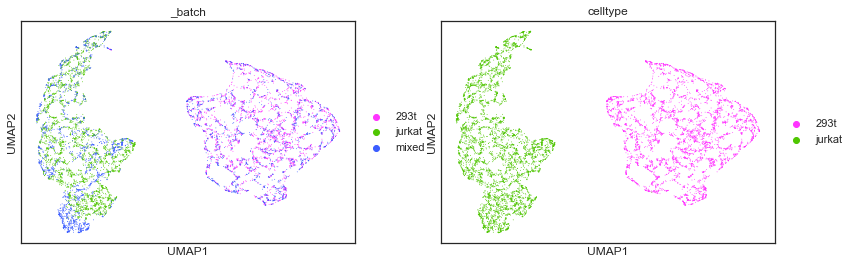

In [30]:
import umap
adata_integrate.obsm['X_umap']=umap.UMAP().fit_transform(adata_integrate.obsm['X_davae'])
adata_integrate.uns['_batch_colors'] = ['#FF34FF', '#4FC601', '#3B5DFF']
sc.pl.umap(adata_integrate, color=['_batch', 'celltype'], s=3)